In [78]:
import pandas as pd
import json


**load the data**

In [79]:
metrics = "../experiments/exp2/metrics/embedding/retrieved_query_documents_aggregated_metrics.json"

with open(metrics, "r", encoding="utf-8") as f:
    data = json.load(f)
    
print(data)

[{'k': 1, 'model': 'BAAI/bge-small-en-v1.5', 'config': 'config_1', 'precision@k': 0.75, 'recall@k': 0.03784725440412002, 'MAP@k': 0.75, 'NDCG@k': 0.9, 'MRR@k': 0.5}, {'k': 1, 'model': 'Snowflake/snowflake-arctic-embed-m', 'config': 'config_1', 'precision@k': 0.35, 'recall@k': 0.017320204225556586, 'MAP@k': 0.225, 'NDCG@k': 0.65, 'MRR@k': 0.125}, {'k': 1, 'model': 'Snowflake/snowflake-arctic-embed-m-v1.5', 'config': 'config_1', 'precision@k': 0.64375, 'recall@k': 0.030487525005779875, 'MAP@k': 0.525, 'NDCG@k': 0.875, 'MRR@k': 0.375}, {'k': 1, 'model': 'intfloat/e5-base-v2', 'config': 'config_1', 'precision@k': 0.70625, 'recall@k': 0.03634860304869727, 'MAP@k': 0.675, 'NDCG@k': 0.925, 'MRR@k': 0.4}, {'k': 1, 'model': 'mixedbread-ai/mxbai-embed-xsmall-v1', 'config': 'config_1', 'precision@k': 0.66875, 'recall@k': 0.0331356931163195, 'MAP@k': 0.675, 'NDCG@k': 0.9, 'MRR@k': 0.325}, {'k': 1, 'model': 'moranmiz/recipe-sbert-model', 'config': 'config_1', 'precision@k': 0.51875, 'recall@k': 0.0

**print all metrics**

In [80]:
df = pd.DataFrame(data)


k_values = sorted(df['k'].unique())

print("=" * 100)
print("RANKING MODELS BY METRICS FOR EACH K")
print("=" * 100)

for k in k_values:
    # Filter data for current k
    k_data = df[df['k'] == k].copy()
    
    print(f"\n{'='*100}")
    print(f"K = {k}")
    print(f"{'='*100}")
    
    # Rank by Precision@k
    print(f"\n📊 RANKED BY PRECISION@{k}:")
    print("-" * 80)
    precision_ranked = k_data.sort_values('precision@k', ascending=False)
    for idx, row in precision_ranked.iterrows():
        print(f"  {row['model']:30} | {row['config']:15} | Precision@{k}: {row['precision@k']:.4f}")
    
    # Rank by Recall@k
    print(f"\n📊 RANKED BY RECALL@{k}:")
    print("-" * 80)
    recall_ranked = k_data.sort_values('recall@k', ascending=False)
    for idx, row in recall_ranked.iterrows():
        print(f"  {row['model']:30} | {row['config']:15} | Recall@{k}: {row['recall@k']:.4f}")
    
    # Rank by NDCG@k
    print(f"\n📊 RANKED BY NDCG@{k}:")
    print("-" * 80)
    ndcg_ranked = k_data.sort_values('NDCG@k', ascending=False)
    for idx, row in ndcg_ranked.iterrows():
        print(f"  {row['model']:30} | {row['config']:15} | NDCG@{k}: {row['NDCG@k']:.4f}")
    
    # Rank by MAP@k
    print(f"\n📊 RANKED BY MAP@{k}:")
    print("-" * 80)
    map_ranked = k_data.sort_values('MAP@k', ascending=False)
    for idx, row in map_ranked.iterrows():
        print(f"  {row['model']:30} | {row['config']:15} | MAP@{k}: {row['MAP@k']:.4f}")
    
    # Rank by MRR@ka
    print(f"\n📊 RANKED BY MRR@{k}:")
    print("-" * 80)
    mrr_ranked = k_data.sort_values('MRR@k', ascending=False)
    for idx, row in mrr_ranked.iterrows():
        print(f"  {row['model']:30} | {row['config']:15} | MRR@{k}: {row['MRR@k']:.4f}")

print("\n" + "=" * 100)
print("SUMMARY: TOP PERFORMERS ACROSS ALL K VALUES")
print("=" * 100)

# Overall best by each metric (averaged across all k)
overall_avg = df.groupby(['model', 'config']).agg({
    'precision@k': 'mean',
    'recall@k': 'mean',
    'NDCG@k': 'mean',
    'MAP@k': 'mean',
    'MRR@k': 'mean'
}).reset_index()

print("\n🏆 BEST AVERAGE PRECISION:")
best_precision = overall_avg.nlargest(3, 'precision@k')
for idx, row in best_precision.iterrows():
    print(f"  {row['model']:30} | {row['config']:15} | Avg Precision: {row['precision@k']:.4f}")

print("\n🏆 BEST AVERAGE RECALL:")
best_recall = overall_avg.nlargest(3, 'recall@k')
for idx, row in best_recall.iterrows():
    print(f"  {row['model']:30} | {row['config']:15} | Avg Recall: {row['recall@k']:.4f}")

print("\n🏆 BEST AVERAGE NDCG:")
best_ndcg = overall_avg.nlargest(3, 'NDCG@k')
for idx, row in best_ndcg.iterrows():
    print(f"  {row['model']:30} | {row['config']:15} | Avg NDCG: {row['NDCG@k']:.4f}")

print("\n🏆 BEST AVERAGE MAP:")
best_map = overall_avg.nlargest(3, 'MAP@k')
for idx, row in best_map.iterrows():
    print(f"  {row['model']:30} | {row['config']:15} | Avg MAP: {row['MAP@k']:.4f}")

print("\n🏆 BEST AVERAGE MRR:")
best_mrr = overall_avg.nlargest(3, 'MRR@k')
for idx, row in best_mrr.iterrows():
    print(f"  {row['model']:30} | {row['config']:15} | Avg MRR: {row['MRR@k']:.4f}")

RANKING MODELS BY METRICS FOR EACH K

K = 1

📊 RANKED BY PRECISION@1:
--------------------------------------------------------------------------------
  BAAI/bge-small-en-v1.5         | config_1        | Precision@1: 0.7500
  thenlper/gte-small             | config_1        | Precision@1: 0.7500
  intfloat/e5-base-v2            | config_1        | Precision@1: 0.7063
  mixedbread-ai/mxbai-embed-xsmall-v1 | config_1        | Precision@1: 0.6687
  sentence-transformers/all-MiniLM-L6-v2 | config_1        | Precision@1: 0.6500
  Snowflake/snowflake-arctic-embed-m-v1.5 | config_1        | Precision@1: 0.6438
  moranmiz/recipe-sbert-model    | config_1        | Precision@1: 0.5188
  Snowflake/snowflake-arctic-embed-m | config_1        | Precision@1: 0.3500

📊 RANKED BY RECALL@1:
--------------------------------------------------------------------------------
  thenlper/gte-small             | config_1        | Recall@1: 0.0390
  BAAI/bge-small-en-v1.5         | config_1        | Recall@1: 0.

In [84]:
# Filter for k=1, k=3, k=5, k=10, and k=20
df_k1 = df[df['k'] == 1][['config', 'model', 'precision@k']].rename(columns={'precision@k': 'precision@1'})
df_k3 = df[df['k'] == 3][['config', 'model', 'precision@k', 'NDCG@k']].rename(columns={'precision@k': 'precision@3', 'NDCG@k': 'NDCG@3'})
df_k5 = df[df['k'] == 5][['config', 'model', 'precision@k', 'NDCG@k']].rename(columns={'precision@k': 'precision@5', 'NDCG@k': 'NDCG@5'})
df_k10 = df[df['k'] == 10][['config', 'model', 'precision@k', 'NDCG@k']].rename(columns={'precision@k': 'precision@10', 'NDCG@k': 'NDCG@10'})
df_k20 = df[df['k'] == 20][['config', 'model', 'precision@k', 'NDCG@k']].rename(columns={'precision@k': 'precision@20', 'NDCG@k': 'NDCG@20'})

# Merge all dataframes
df_merged = (df_k1
             .merge(df_k3, on=['config', 'model'])
             .merge(df_k5, on=['config', 'model'])
             .merge(df_k10, on=['config', 'model'])
             .merge(df_k20, on=['config', 'model']))

# Calculate combined metric (average of 9 metrics)
df_merged['combined_metric'] = \
    df_merged['precision@1'] * 0.25 + \
    df_merged['precision@3'] * 0.2 + \
    df_merged['precision@5'] * 0.15 + \
    df_merged['NDCG@3'] * 0.15 + \
    df_merged['NDCG@5'] * 0.15 + \
    df_merged['NDCG@10'] * 0.1 


# Round for better display
df_merged = df_merged.round(4)

# Sort by combined metric to see best configs
df_sorted = df_merged.sort_values('combined_metric', ascending=False)
print("\nBest performing configs:")
df_sorted


Best performing configs:


,config,model,precision@1,precision@3,NDCG@3,precision@5,NDCG@5,precision@10,NDCG@10,precision@20,NDCG@20,combined_metric
0,config_1,BAAI/bge-small-en-v1.5,0.7500,0.6750,0.9343,0.5838,0.9216,0.5062,0.8958,0.4456,0.8718,0.7780
7,config_1,thenlper/gte-small,0.7500,0.6312,0.9345,0.5838,0.9106,0.5188,0.8848,0.4662,0.8718,0.7665
3,config_1,intfloat/e5-base-v2,0.7062,0.6312,0.9197,0.5988,0.9109,0.5338,0.8837,0.4778,0.8718,0.7556
4,config_1,mixedbread-ai/mxbai-embed-xsmall-v1,0.6688,0.6125,0.9105,0.5562,0.8961,0.4850,0.8745,0.4266,0.8525,0.7316
6,config_1,sentence-transformers/all-MiniLM-L6-v2,0.6500,0.6042,0.8790,0.5425,0.8688,0.4625,0.8628,0.4372,0.8428,0.7132
2,config_1,Snowflake/snowflake-arctic-embed-m-v1.5,0.6438,0.5854,0.8810,0.5425,0.8740,0.4519,0.8525,0.3916,0.8351,0.7079
5,config_1,moranmiz/recipe-sbert-model,0.5188,0.4958,0.8506,0.4925,0.8208,0.4562,0.8078,0.4109,0.8074,0.6342
1,config_1,Snowflake/snowflake-arctic-embed-m,0.3500,0.3833,0.7835,0.3500,0.7618,0.2962,0.7355,0.2734,0.7230,0.5220


In [83]:
# Filter for k=1, k=3, k=5, k=10, and k=20
df_k10 = df[df['k'] == 10][['config', 'model', 'recall@k']].rename(columns={'recall@k': 'recall@10'})
df_k20 = df[df['k'] == 20][['config', 'model', 'recall@k']].rename(columns={'recall@k': 'recall@20'})

# Merge all dataframes
df_merged = (df_k10
             .merge(df_k20, on=['config', 'model']))

# Calculate combined metric (average of 9 metrics)
df_merged['combined_metric'] = \
    df_merged['recall@10'] * 0.4 + \
    df_merged['recall@20'] * 0.6 


# Round for better display
df_merged = df_merged.round(4)

# Sort by combined metric to see best configs
df_sorted = df_merged.sort_values('combined_metric', ascending=False)
print("\nBest performing configs:")
df_sorted


Best performing configs:


,config,model,recall@10,recall@20,combined_metric
3,config_1,intfloat/e5-base-v2,0.2334,0.4098,0.3392
7,config_1,thenlper/gte-small,0.2306,0.3963,0.3300
0,config_1,BAAI/bge-small-en-v1.5,0.2255,0.3759,0.3158
6,config_1,sentence-transformers/all-MiniLM-L6-v2,0.2023,0.3611,0.2976
4,config_1,mixedbread-ai/mxbai-embed-xsmall-v1,0.2058,0.3514,0.2932
2,config_1,Snowflake/snowflake-arctic-embed-m-v1.5,0.2044,0.3451,0.2888
5,config_1,moranmiz/recipe-sbert-model,0.1985,0.3446,0.2862
1,config_1,Snowflake/snowflake-arctic-embed-m,0.1243,0.2241,0.1842


ValueError: x and y must have same first dimension, but have shapes (5,) and (40,)

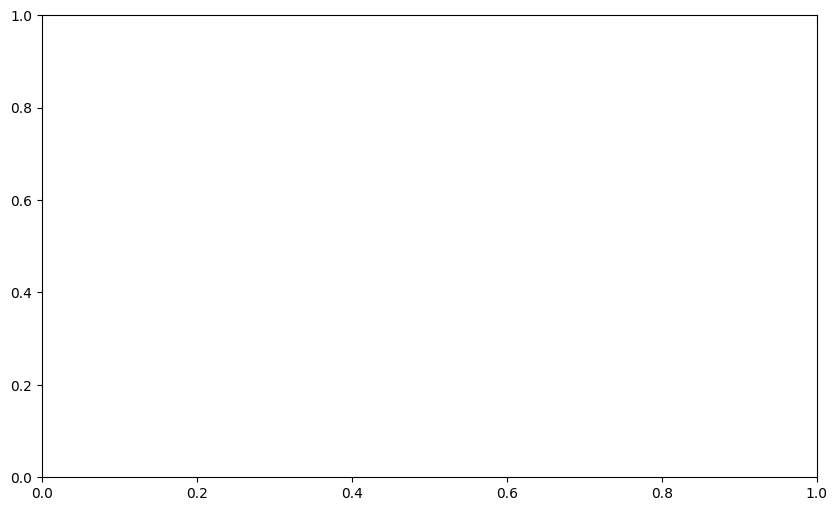

In [82]:
import matplotlib.pyplot as plt
import pandas as pd

# Filter for config_1 and config_5
df_config1 = df[df['config'] == 'config_1']
df_config5 = df[df['config'] == 'config_5']

# Extract k values and precision values
k_values = [1, 3, 5, 10, 20]

# Get precision values for each config
precision_config1 = df_config1[df_config1['k'].isin(k_values)].sort_values('k')['precision@k'].values
precision_config5 = df_config5[df_config5['k'].isin(k_values)].sort_values('k')['precision@k'].values

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(k_values, precision_config1, marker='o', label='Config 1', linewidth=2, markersize=8)
plt.plot(k_values, precision_config5, marker='s', label='Config 5', linewidth=2, markersize=8)

plt.xlabel('K (Number of Retrieved Documents)', fontsize=12)
plt.ylabel('Precision@K', fontsize=12)
plt.title('Precision@K Comparison: Config 1 vs Config 5', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(k_values)

# Add value labels on points
for i, k in enumerate(k_values):
    plt.text(k, precision_config1[i], f'{precision_config1[i]:.3f}', 
             ha='center', va='bottom', fontsize=9)
    plt.text(k, precision_config5[i], f'{precision_config5[i]:.3f}', 
             ha='center', va='top', fontsize=9)

plt.tight_layout()
plt.show()